# 1. Data exploration

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("WineQT.csv", sep=",")
df = df.drop(columns="Id")
print(df.describe())

       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1143.000000       1143.000000  1143.000000     1143.000000   
mean        8.311111          0.531339     0.268364        2.532152   
std         1.747595          0.179633     0.196686        1.355917   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.392500     0.090000        1.900000   
50%         7.900000          0.520000     0.250000        2.200000   
75%         9.100000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1143.000000          1143.000000           1143.000000  1143.000000   
mean      0.086933            15.615486             45.914698     0.996730   
std       0.047267            10.250486             32.782130     0.001925   
min       0.012000             1.000000         

In [3]:
def plot_hists(df):
    _, ax = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))
    for n in range(12):
        i = n % 3
        j = n % 4
        ax[i, j].hist(df.iloc[:, n], bins='auto')
        ax[i, j].set_xlabel(df.columns[n])

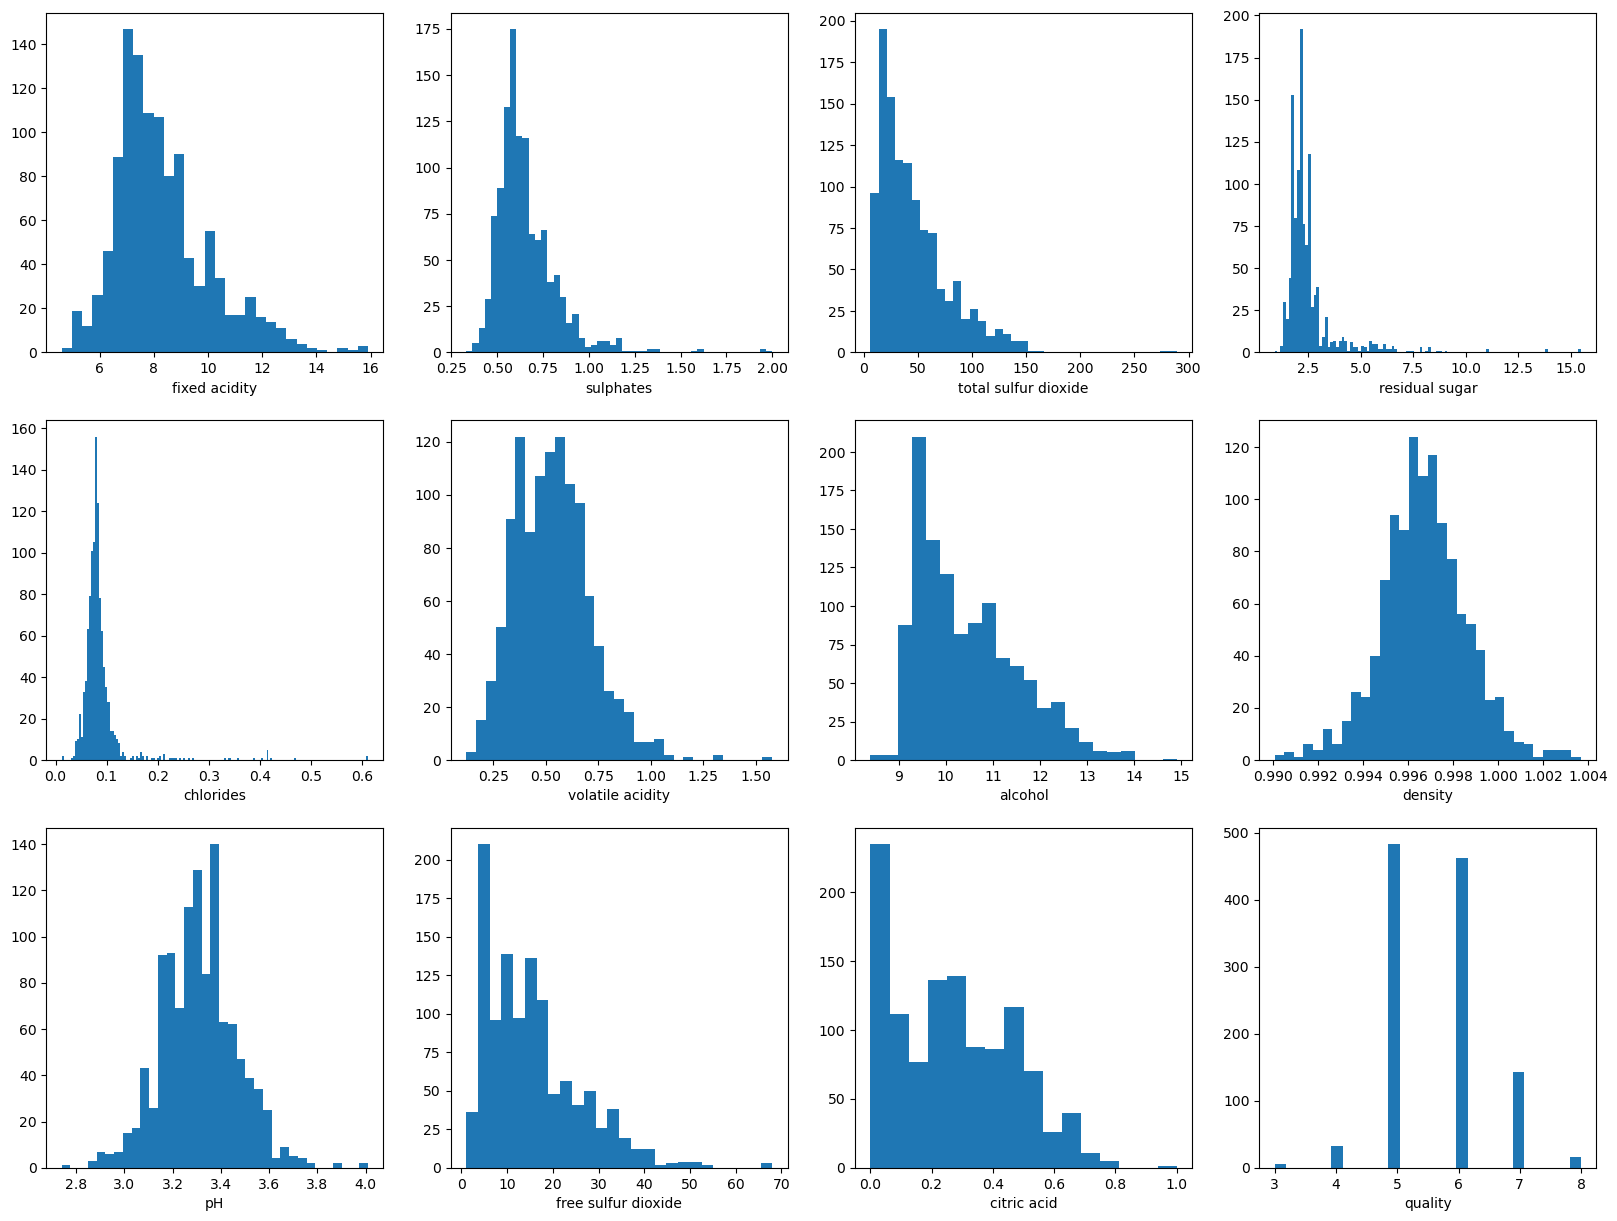

In [4]:
plot_hists(df)

# 2. Data preprocessing

## 2.1 Anomaly detection

d:\Programs\Miniconda\envs\env\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


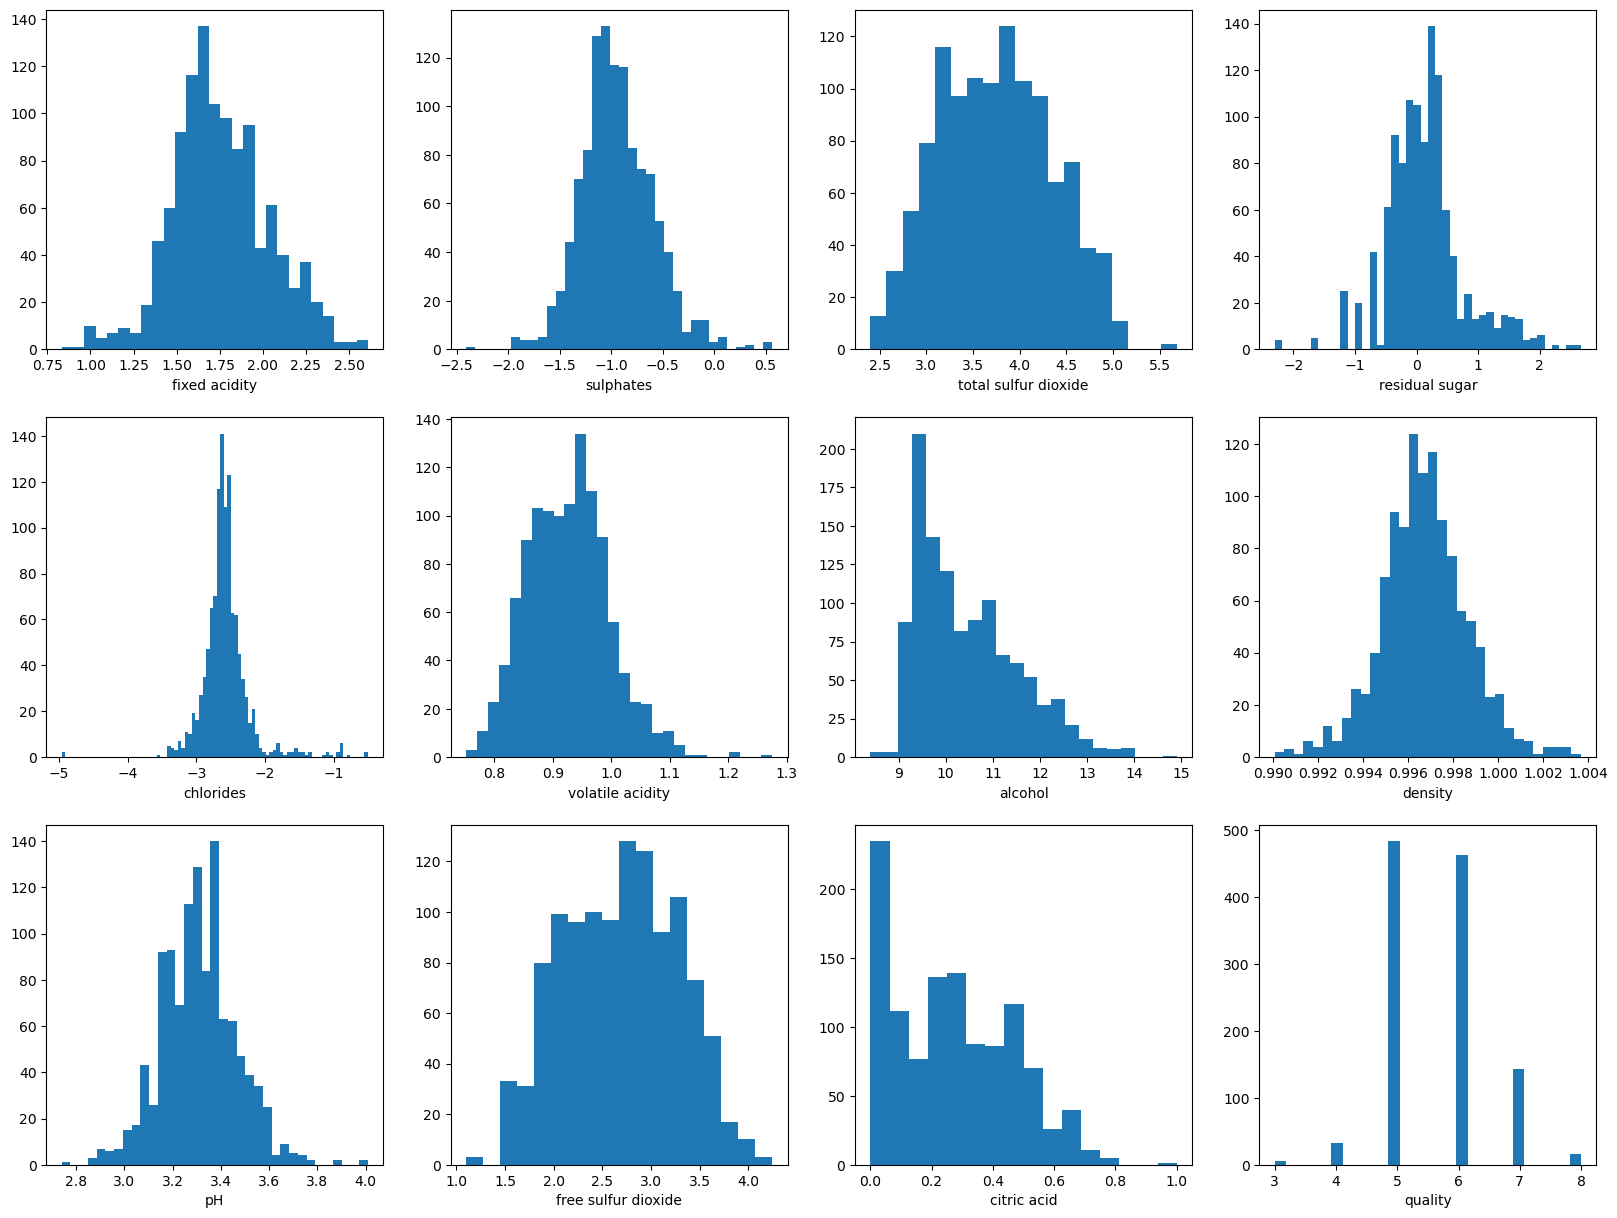

In [5]:
def normalize(df, property, parameter):
    df[property] = np.log(df[property] + parameter)

normalize(df, "fixed acidity", -2.3)
normalize(df, "sulphates", -0.24)
normalize(df, "total sulfur dioxide", 5)
normalize(df, "residual sugar", -1.1)
normalize(df, "chlorides", -0.005)
normalize(df, "volatile acidity", 2)
normalize(df, "free sulfur dioxide", 2)
plot_hists(df);

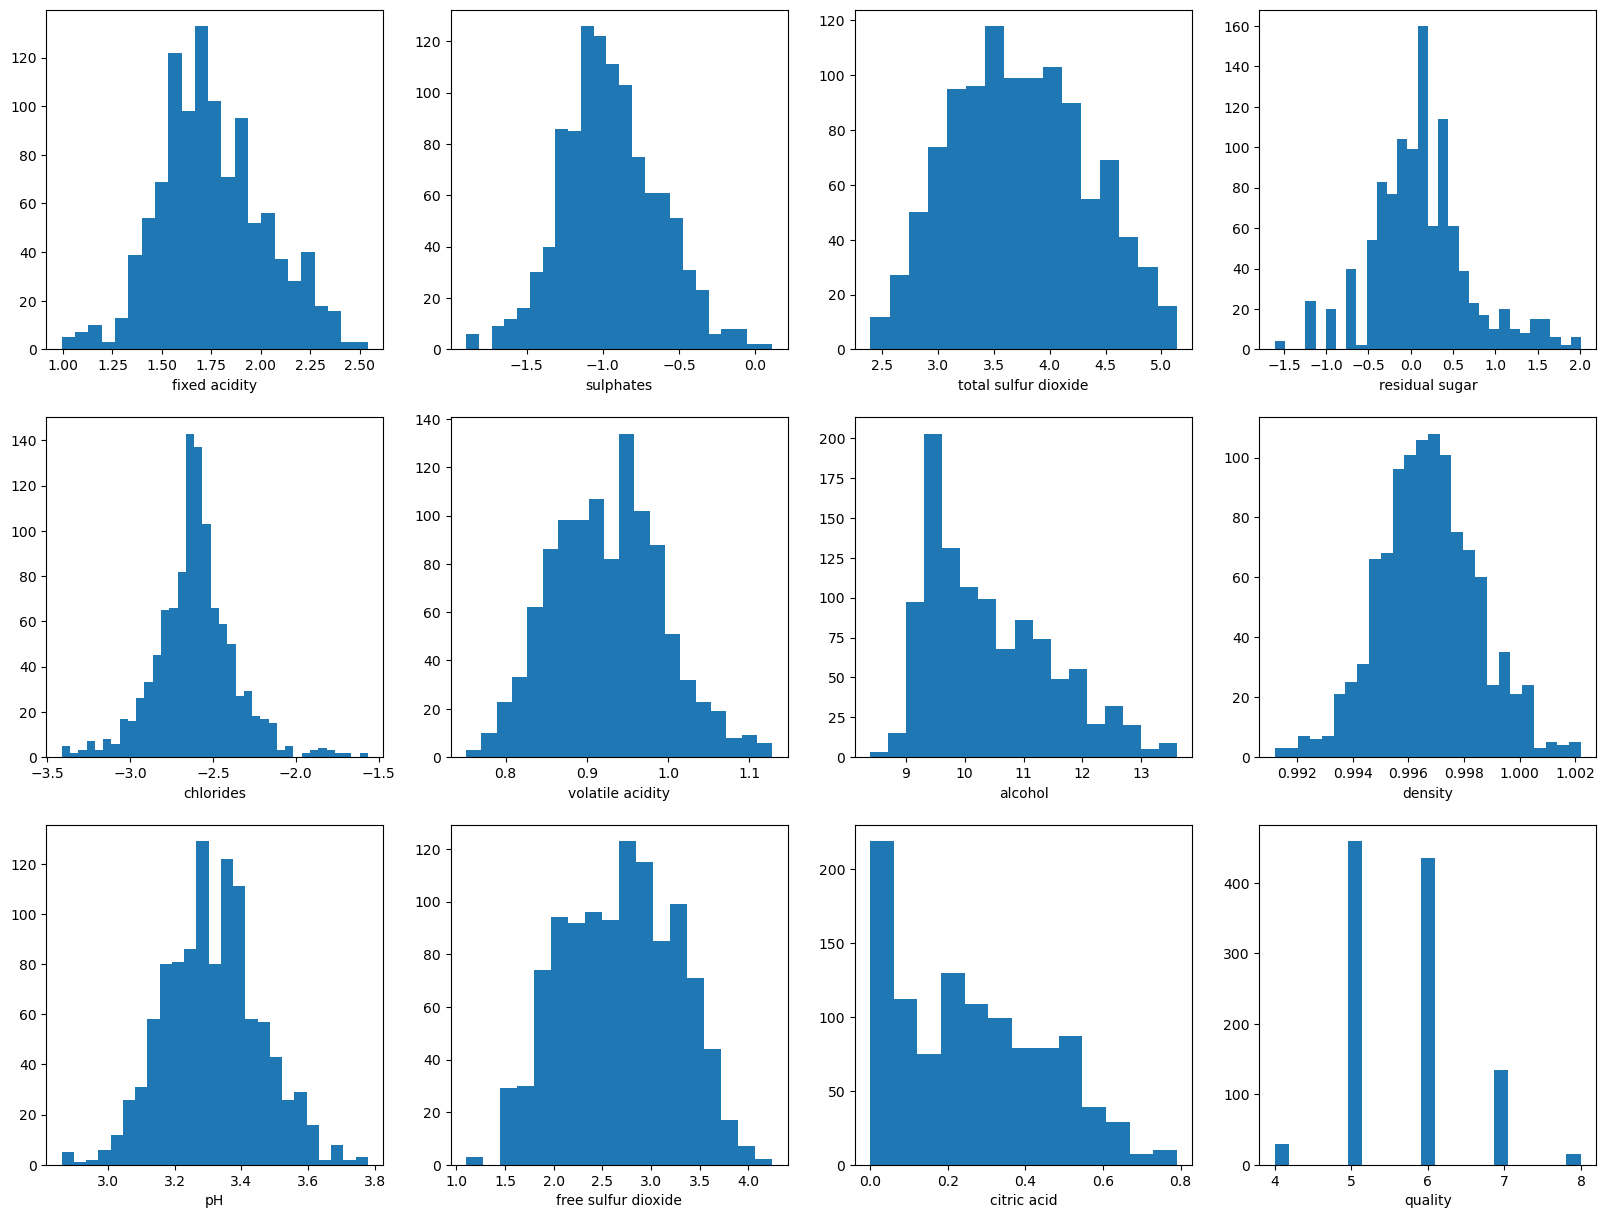

In [6]:
standardized = (df - df.mean()) / df.std()
standardized = standardized[(np.abs(standardized) < 3).all(axis=1)]
rows = np.setdiff1d(list(df.index), list(standardized.index))
df.drop(index=rows, inplace=True) # Delete observations with std >= 3
plot_hists(df)

## 2.2 Mulitcolinearity detection

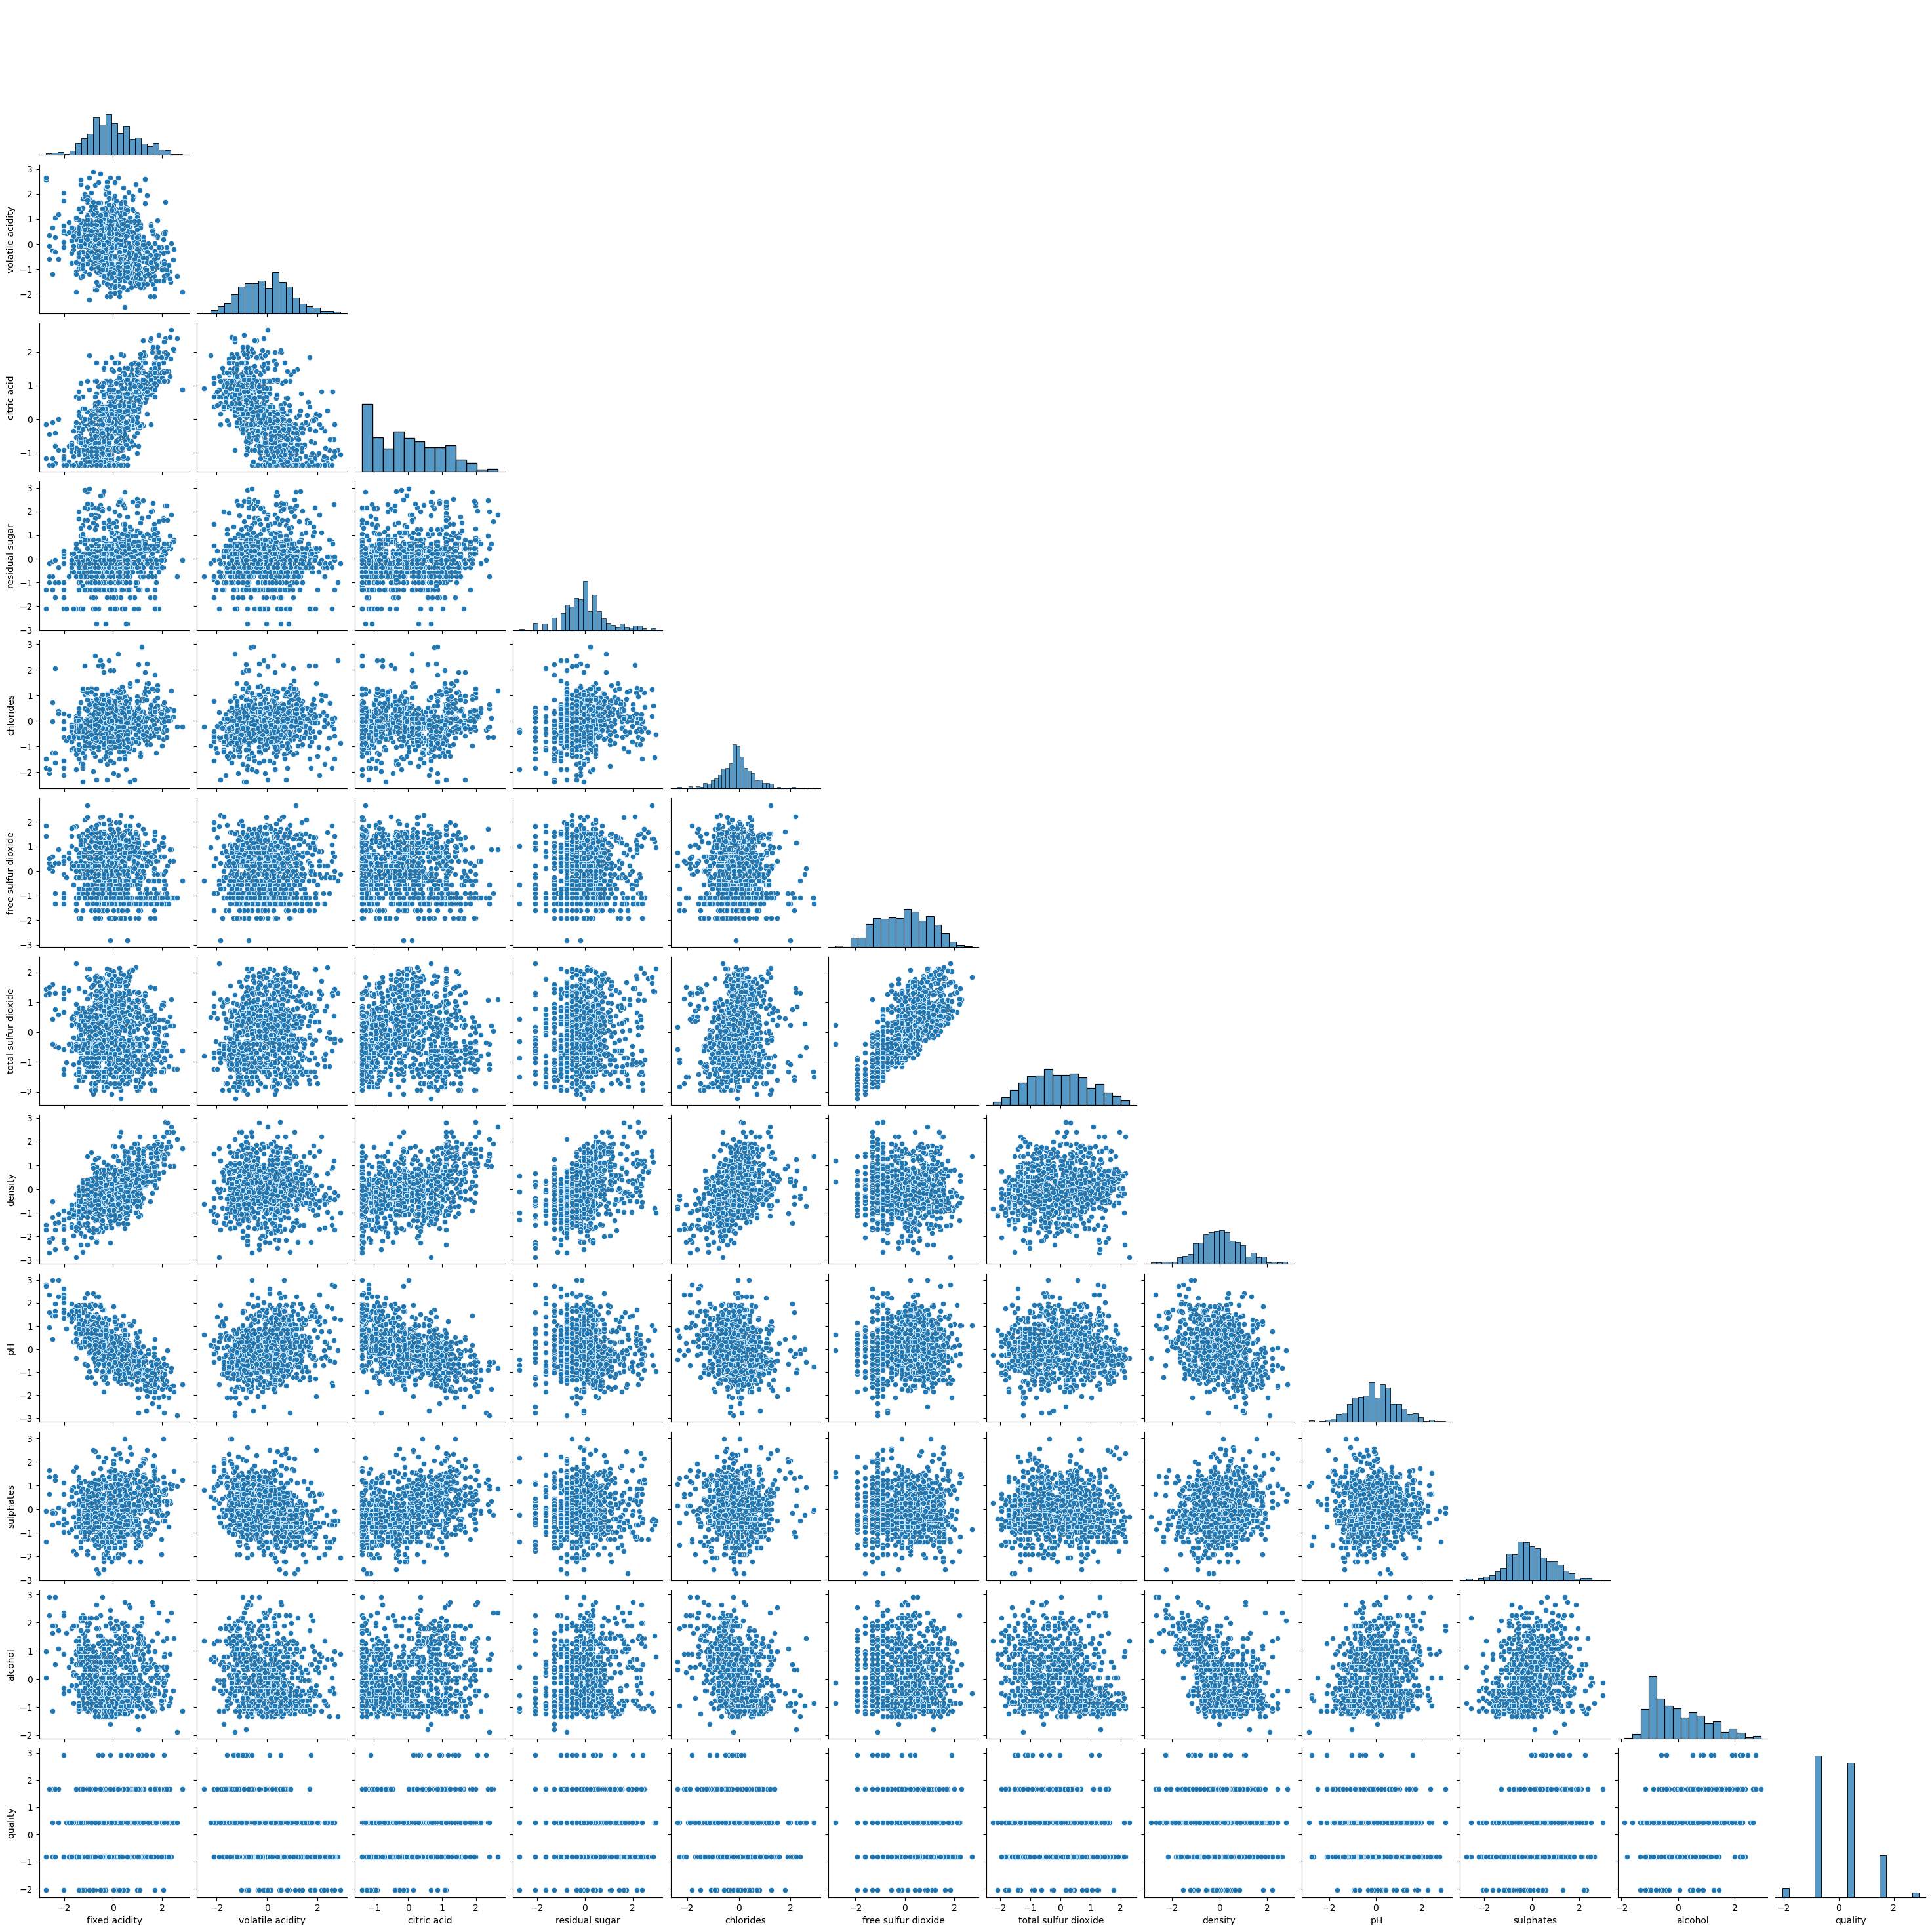

In [7]:
sns.pairplot(standardized, corner=True);

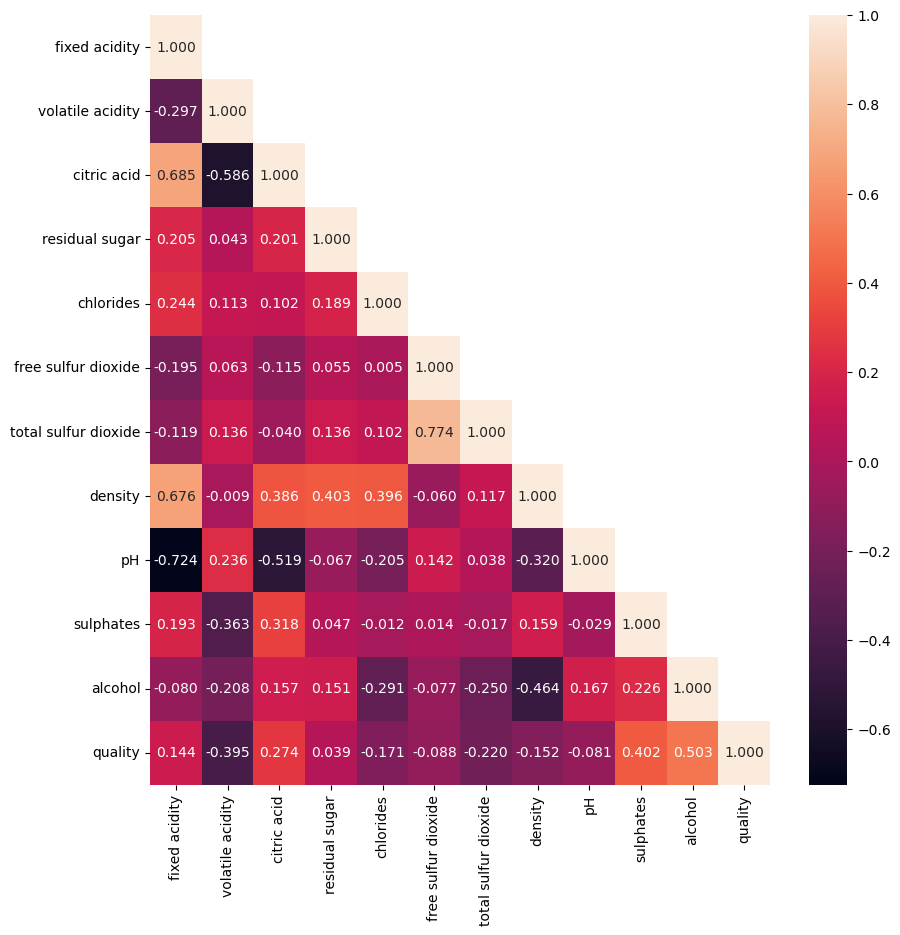

In [8]:
corr = standardized.corr()
matrix = np.triu(corr, 1)
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(corr, annot=True, fmt=".3f", mask=matrix)

In [9]:
np.fill_diagonal(corr.values, 0)
def delete(corr, df): # Delete all labels with coef >= 0.7
    tmp = corr.loc[:, (np.abs(corr) >= 0.7).any()]
    print((tmp.columns))
    if (len(tmp.columns) > 0):
        label = np.abs(tmp).sum().sort_values(ascending=False).index[0]
        corr.drop(index=label, columns=label, inplace=True)
        df.drop(columns=label, inplace=True)
        delete(corr, df)
delete(corr, df)
print(df.describe());

Index(['fixed acidity', 'free sulfur dioxide', 'total sulfur dioxide', 'pH'], dtype='object')
Index(['free sulfur dioxide', 'total sulfur dioxide'], dtype='object')
Index([], dtype='object')
       volatile acidity  citric acid  residual sugar    chlorides  \
count       1074.000000  1074.000000     1074.000000  1074.000000   
mean           0.925244     0.262793        0.117516    -2.603734   
std            0.067709     0.191576        0.577733     0.242205   
min            0.751416     0.000000       -1.609438    -3.411248   
25%            0.871293     0.090000       -0.223144    -2.733368   
50%            0.924259     0.250000        0.095310    -2.603690   
75%            0.970779     0.420000        0.405465    -2.476938   
max            1.128171     0.790000        2.014903    -1.565421   

       free sulfur dioxide      density           pH    sulphates  \
count          1074.000000  1074.000000  1074.000000  1074.000000   
mean              2.702034     0.996727     3.314

## 2.3 Feature scaling

In [10]:
from sklearn.model_selection import train_test_split

X = np.c_[df.iloc[:, :-1].to_numpy(), np.ones(df.shape[0])]
y = df["quality"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# 3. Model selection

In [12]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

cv = KFold(n_splits=10)

## 3.1 K-Neighbors

In [13]:
from sklearn.neighbors import KNeighborsClassifier

parameters = {
    'n_neighbors': [10, 11, 12, 13, 14, 15],
    'weights': ('uniform', 'distance'),
    'p': [1, 2]
}
knc = KNeighborsClassifier(algorithm='auto')
clf = GridSearchCV(knc, parameters, scoring='accuracy', cv=cv)
clf.fit(X_train, y_train);

In [14]:
print(f"Best score : {clf.best_score_}")
print(f"Best parameters : {clf.best_params_}")

Best score : 0.672859097127223
Best parameters : {'n_neighbors': 11, 'p': 1, 'weights': 'distance'}


## 3.2 SVC

In [15]:
from sklearn.svm import SVC

parameters = {
    'kernel': ('linear', 'rbf'),
    'C': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
}
svc = SVC()
clf = GridSearchCV(svc, parameters, scoring='accuracy', cv=cv)
clf.fit(X_train, y_train);

In [16]:
print(f"Best score : {clf.best_score_}")
print(f"Best parameters : {clf.best_params_}")

Best score : 0.6332831737346101
Best parameters : {'C': 5, 'kernel': 'rbf'}


## 3.3 Random Forest

In [17]:
from sklearn.ensemble import RandomForestClassifier

parameters = {
    'n_estimators': [100, 200, 300],
    'criterion': ('gini', 'entropy', 'log_loss')
}
rfc = RandomForestClassifier()
clf = GridSearchCV(rfc, parameters, scoring='accuracy', cv=cv)
clf.fit(X_train, y_train);

In [18]:
print(f"Best score : {clf.best_score_}")
print(f"Best parameters : {clf.best_params_}")

Best score : 0.6845690834473325
Best parameters : {'criterion': 'log_loss', 'n_estimators': 200}


## 3.4 XGBoost

In [19]:
from xgboost import XGBClassifier

y_map = y_train - 4

parameters = {
    "learning_rate": [0.1, 0.3, 0.6, 1],
    "max_depth": [5, 6, 7, 8, 9, 10]
}
xgbc = XGBClassifier(objective="multi:softmax", random_state=42)
clf = GridSearchCV(xgbc, parameters, scoring='accuracy', cv=cv)
clf.fit(X_train, y_map);

In [20]:
print(f"Best score : {clf.best_score_}")
print(f"Best parameters : {clf.best_params_}")

Best score : 0.6601231190150479
Best parameters : {'learning_rate': 0.6, 'max_depth': 9}


# 4. Model evaluation

In [21]:
clt = RandomForestClassifier(n_estimators=200, criterion='entropy')
clt.fit(X_train, y_train)
y_pred = clt.predict(X_test)

In [22]:
from sklearn.metrics import accuracy_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy : {accuracy}")
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1-score : {f1}")

Accuracy : 0.6465116279069767
F1-score : 0.6297774848570442
